# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

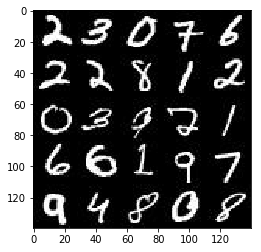

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

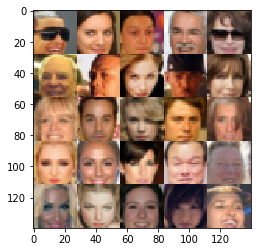

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images")
    input_zs = tf.placeholder(tf.float32, (None, z_dim), name='input_zs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    #return inputs_real, inputs_z
    return input_images, input_zs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha=0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_images, input_zs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, input_zs, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    n_step=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                n_step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                
                if n_step % 100 == 0:
                    show_generator_output(sess, 25, input_zs, data_shape[3], data_image_mode)
                
                if n_step % 20 == 0:                    
                    train_loss_d = d_loss.eval({input_zs: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_zs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6904... Generator Loss: 0.1873
Epoch 1/2... Discriminator Loss: 2.0327... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.7737... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.7491... Generator Loss: 0.4486


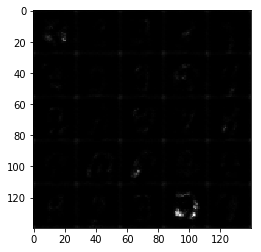

Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 1.8101... Generator Loss: 0.4052
Epoch 1/2... Discriminator Loss: 2.0815... Generator Loss: 1.5472
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.5419


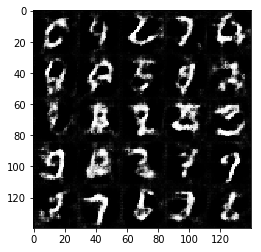

Epoch 1/2... Discriminator Loss: 1.6979... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.3931
Epoch 1/2... Discriminator Loss: 1.6803... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 1.6844... Generator Loss: 0.3736


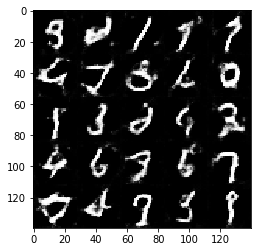

Epoch 1/2... Discriminator Loss: 1.6490... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 0.3635
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.7181... Generator Loss: 0.3466


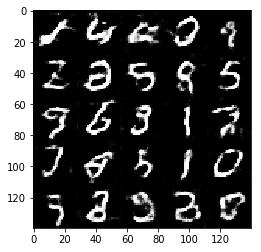

Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.8758... Generator Loss: 0.2959


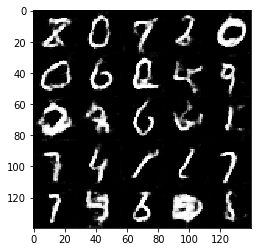

Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.6373... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.8458... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.5260


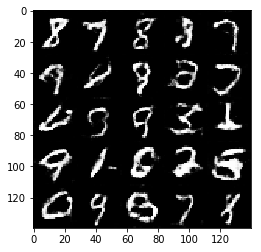

Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.4802
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.5044


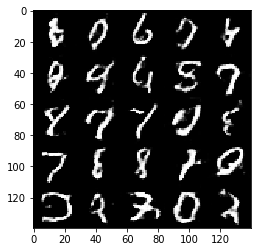

Epoch 1/2... Discriminator Loss: 1.8458... Generator Loss: 0.2808
Epoch 1/2... Discriminator Loss: 1.6554... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.8504... Generator Loss: 0.2791
Epoch 1/2... Discriminator Loss: 1.7235... Generator Loss: 0.3418


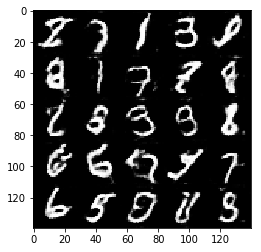

Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.5580


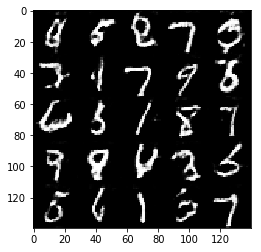

Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.5829


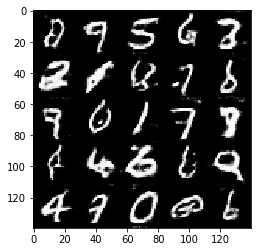

Epoch 2/2... Discriminator Loss: 1.6149... Generator Loss: 0.3917
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.5831
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.5623


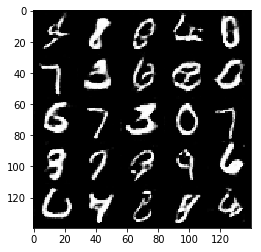

Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.6029... Generator Loss: 0.4177
Epoch 2/2... Discriminator Loss: 1.7070... Generator Loss: 0.3654
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.6271


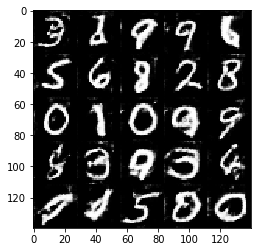

Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.3386
Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 1.6745... Generator Loss: 1.6727


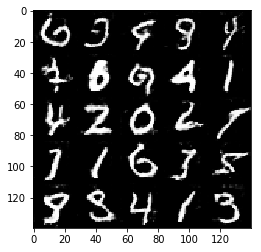

Epoch 2/2... Discriminator Loss: 1.6662... Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 1.8121... Generator Loss: 0.3197
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 0.5960


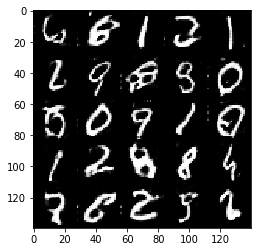

Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.4526... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.7931


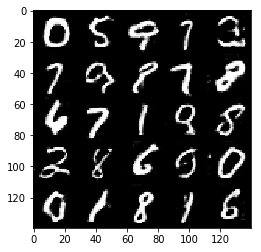

Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.6447
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.4735... Generator Loss: 0.5746
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.7005


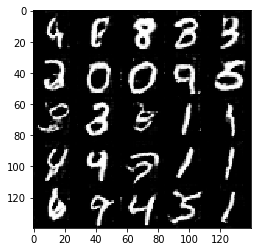

Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.7710... Generator Loss: 0.3638
Epoch 2/2... Discriminator Loss: 1.7613... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 0.4497


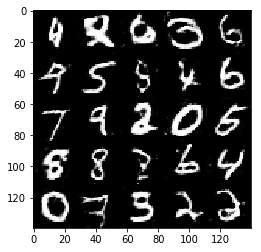

Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.6469... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 0.4532


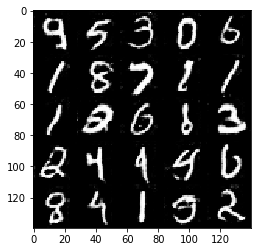

Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 1.0633


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 2.8879... Generator Loss: 0.1564
Epoch 1/3... Discriminator Loss: 1.8958... Generator Loss: 0.3702
Epoch 1/3... Discriminator Loss: 2.1661... Generator Loss: 0.2266
Epoch 1/3... Discriminator Loss: 1.5146... Generator Loss: 0.5200


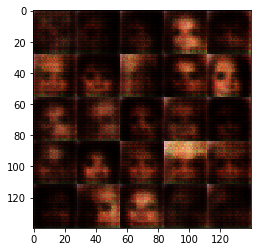

Epoch 1/3... Discriminator Loss: 1.7542... Generator Loss: 0.5468
Epoch 1/3... Discriminator Loss: 1.5655... Generator Loss: 0.6015
Epoch 1/3... Discriminator Loss: 1.4530... Generator Loss: 0.6267
Epoch 1/3... Discriminator Loss: 1.7374... Generator Loss: 0.4953
Epoch 1/3... Discriminator Loss: 1.4474... Generator Loss: 0.6926


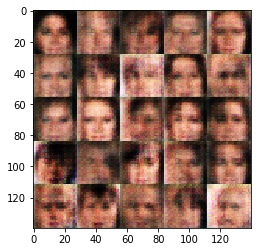

Epoch 1/3... Discriminator Loss: 1.7587... Generator Loss: 0.6097
Epoch 1/3... Discriminator Loss: 1.5758... Generator Loss: 0.6606
Epoch 1/3... Discriminator Loss: 1.4333... Generator Loss: 0.7247
Epoch 1/3... Discriminator Loss: 1.6725... Generator Loss: 0.5288
Epoch 1/3... Discriminator Loss: 1.5851... Generator Loss: 0.8950


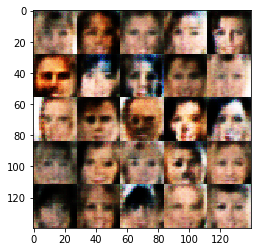

Epoch 1/3... Discriminator Loss: 1.6838... Generator Loss: 0.5171
Epoch 1/3... Discriminator Loss: 1.2054... Generator Loss: 1.7780
Epoch 1/3... Discriminator Loss: 1.7753... Generator Loss: 0.7502
Epoch 1/3... Discriminator Loss: 1.6099... Generator Loss: 0.5906
Epoch 1/3... Discriminator Loss: 1.5228... Generator Loss: 0.7222


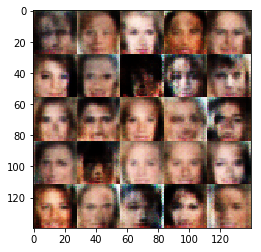

Epoch 1/3... Discriminator Loss: 1.4747... Generator Loss: 0.7503
Epoch 1/3... Discriminator Loss: 1.4844... Generator Loss: 0.7005
Epoch 1/3... Discriminator Loss: 1.4961... Generator Loss: 0.7220
Epoch 1/3... Discriminator Loss: 1.4672... Generator Loss: 0.7016
Epoch 1/3... Discriminator Loss: 1.4495... Generator Loss: 0.6481


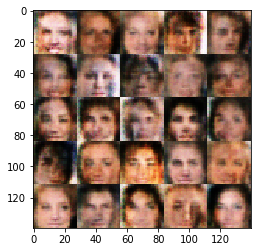

Epoch 1/3... Discriminator Loss: 1.4821... Generator Loss: 0.6976
Epoch 1/3... Discriminator Loss: 1.5220... Generator Loss: 0.7056
Epoch 1/3... Discriminator Loss: 1.4482... Generator Loss: 0.7183
Epoch 1/3... Discriminator Loss: 1.5110... Generator Loss: 0.6970
Epoch 1/3... Discriminator Loss: 1.4153... Generator Loss: 0.9003


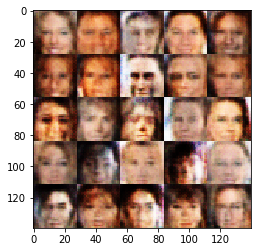

Epoch 1/3... Discriminator Loss: 1.4472... Generator Loss: 0.7324
Epoch 1/3... Discriminator Loss: 1.4535... Generator Loss: 0.7409
Epoch 1/3... Discriminator Loss: 1.3795... Generator Loss: 0.7681
Epoch 1/3... Discriminator Loss: 1.4074... Generator Loss: 0.7090
Epoch 1/3... Discriminator Loss: 1.5276... Generator Loss: 0.7134


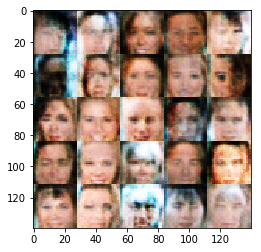

Epoch 1/3... Discriminator Loss: 1.4295... Generator Loss: 0.7382
Epoch 1/3... Discriminator Loss: 1.5230... Generator Loss: 0.7494
Epoch 1/3... Discriminator Loss: 1.5320... Generator Loss: 0.6579
Epoch 1/3... Discriminator Loss: 1.4385... Generator Loss: 0.7339
Epoch 1/3... Discriminator Loss: 1.5369... Generator Loss: 0.6593


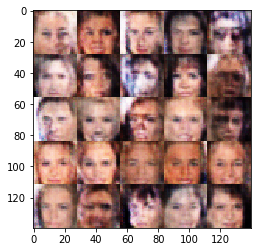

Epoch 1/3... Discriminator Loss: 1.4031... Generator Loss: 0.7815
Epoch 1/3... Discriminator Loss: 1.4450... Generator Loss: 0.7475
Epoch 1/3... Discriminator Loss: 1.4504... Generator Loss: 0.7778
Epoch 1/3... Discriminator Loss: 1.3970... Generator Loss: 0.7658
Epoch 1/3... Discriminator Loss: 1.4454... Generator Loss: 0.7140


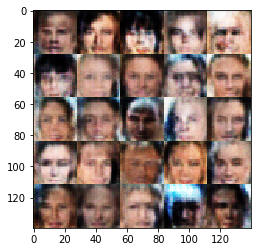

Epoch 1/3... Discriminator Loss: 1.4255... Generator Loss: 0.7732
Epoch 1/3... Discriminator Loss: 1.4831... Generator Loss: 0.6946
Epoch 1/3... Discriminator Loss: 1.4235... Generator Loss: 0.6904
Epoch 1/3... Discriminator Loss: 1.4419... Generator Loss: 0.7099
Epoch 1/3... Discriminator Loss: 1.4704... Generator Loss: 0.7617


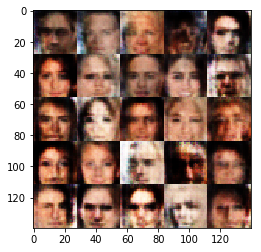

Epoch 1/3... Discriminator Loss: 1.4376... Generator Loss: 0.7297
Epoch 1/3... Discriminator Loss: 1.4200... Generator Loss: 0.6522
Epoch 1/3... Discriminator Loss: 1.5178... Generator Loss: 0.7487
Epoch 1/3... Discriminator Loss: 1.4757... Generator Loss: 0.8032
Epoch 1/3... Discriminator Loss: 1.4510... Generator Loss: 0.6231


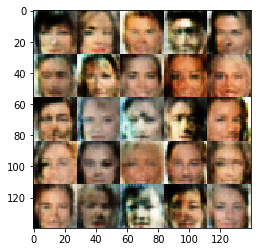

Epoch 1/3... Discriminator Loss: 1.4160... Generator Loss: 0.7828
Epoch 1/3... Discriminator Loss: 1.4490... Generator Loss: 0.7079
Epoch 1/3... Discriminator Loss: 1.4364... Generator Loss: 0.6993
Epoch 1/3... Discriminator Loss: 1.4667... Generator Loss: 0.6883
Epoch 1/3... Discriminator Loss: 1.5502... Generator Loss: 0.8964


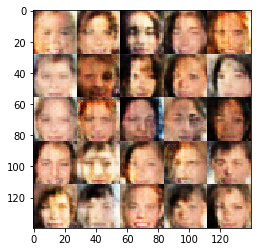

Epoch 1/3... Discriminator Loss: 1.4801... Generator Loss: 0.6978
Epoch 1/3... Discriminator Loss: 1.4151... Generator Loss: 0.7393
Epoch 1/3... Discriminator Loss: 1.4643... Generator Loss: 0.6696
Epoch 1/3... Discriminator Loss: 1.4826... Generator Loss: 0.6717
Epoch 1/3... Discriminator Loss: 1.4624... Generator Loss: 0.7407


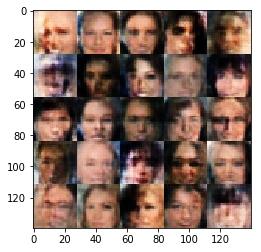

Epoch 1/3... Discriminator Loss: 1.4580... Generator Loss: 0.9114
Epoch 1/3... Discriminator Loss: 1.5680... Generator Loss: 0.5780
Epoch 1/3... Discriminator Loss: 1.4398... Generator Loss: 0.6915
Epoch 1/3... Discriminator Loss: 1.4521... Generator Loss: 0.6942
Epoch 1/3... Discriminator Loss: 1.5833... Generator Loss: 0.7857


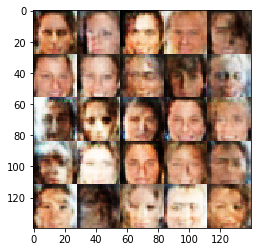

Epoch 1/3... Discriminator Loss: 1.4283... Generator Loss: 0.6137
Epoch 1/3... Discriminator Loss: 1.4290... Generator Loss: 0.8631
Epoch 1/3... Discriminator Loss: 1.4261... Generator Loss: 0.6779
Epoch 1/3... Discriminator Loss: 1.4807... Generator Loss: 0.6824
Epoch 1/3... Discriminator Loss: 1.5368... Generator Loss: 0.6232


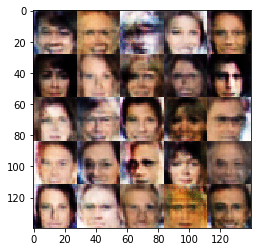

Epoch 1/3... Discriminator Loss: 1.4383... Generator Loss: 0.7030
Epoch 1/3... Discriminator Loss: 1.4054... Generator Loss: 0.7733
Epoch 1/3... Discriminator Loss: 1.4488... Generator Loss: 0.6830
Epoch 1/3... Discriminator Loss: 1.4481... Generator Loss: 0.7224
Epoch 1/3... Discriminator Loss: 1.4672... Generator Loss: 0.7317


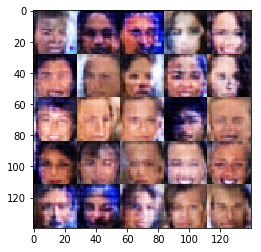

Epoch 1/3... Discriminator Loss: 1.4612... Generator Loss: 0.6553
Epoch 1/3... Discriminator Loss: 1.4598... Generator Loss: 0.7415
Epoch 1/3... Discriminator Loss: 1.4565... Generator Loss: 0.7498
Epoch 1/3... Discriminator Loss: 1.4686... Generator Loss: 0.6786
Epoch 1/3... Discriminator Loss: 1.4242... Generator Loss: 0.7101


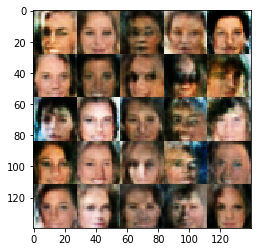

Epoch 1/3... Discriminator Loss: 1.4540... Generator Loss: 0.7609
Epoch 1/3... Discriminator Loss: 1.4191... Generator Loss: 0.7691
Epoch 1/3... Discriminator Loss: 1.5187... Generator Loss: 0.7999
Epoch 1/3... Discriminator Loss: 1.5171... Generator Loss: 0.7689
Epoch 1/3... Discriminator Loss: 1.4481... Generator Loss: 0.7476


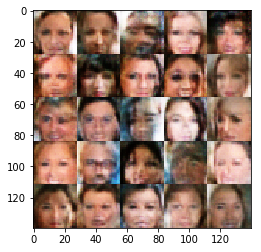

Epoch 1/3... Discriminator Loss: 1.4913... Generator Loss: 0.6648
Epoch 1/3... Discriminator Loss: 1.4461... Generator Loss: 0.7408
Epoch 1/3... Discriminator Loss: 1.4891... Generator Loss: 0.6909
Epoch 1/3... Discriminator Loss: 1.4684... Generator Loss: 0.7070
Epoch 1/3... Discriminator Loss: 1.3912... Generator Loss: 0.7180


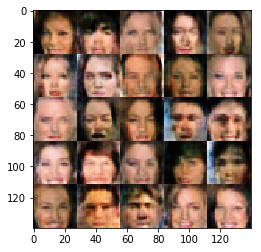

Epoch 1/3... Discriminator Loss: 1.4369... Generator Loss: 0.7132
Epoch 1/3... Discriminator Loss: 1.4440... Generator Loss: 0.7295
Epoch 1/3... Discriminator Loss: 1.4301... Generator Loss: 0.6796
Epoch 1/3... Discriminator Loss: 1.4636... Generator Loss: 0.6351
Epoch 1/3... Discriminator Loss: 1.4964... Generator Loss: 0.7451


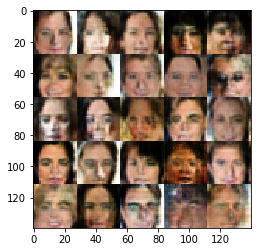

Epoch 1/3... Discriminator Loss: 1.4771... Generator Loss: 0.6022
Epoch 1/3... Discriminator Loss: 1.4861... Generator Loss: 0.6334
Epoch 1/3... Discriminator Loss: 1.4670... Generator Loss: 0.7343
Epoch 1/3... Discriminator Loss: 1.4093... Generator Loss: 0.7978
Epoch 1/3... Discriminator Loss: 1.4649... Generator Loss: 0.7013


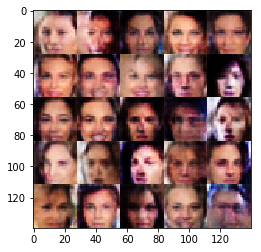

Epoch 1/3... Discriminator Loss: 1.4749... Generator Loss: 0.7338
Epoch 1/3... Discriminator Loss: 1.4198... Generator Loss: 0.7835
Epoch 1/3... Discriminator Loss: 1.4238... Generator Loss: 0.7464
Epoch 1/3... Discriminator Loss: 1.4742... Generator Loss: 0.6068
Epoch 1/3... Discriminator Loss: 1.4402... Generator Loss: 0.7422


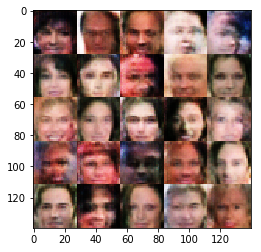

Epoch 1/3... Discriminator Loss: 1.4478... Generator Loss: 0.7658
Epoch 1/3... Discriminator Loss: 1.4073... Generator Loss: 0.7966
Epoch 1/3... Discriminator Loss: 1.4511... Generator Loss: 0.6993
Epoch 1/3... Discriminator Loss: 1.4224... Generator Loss: 0.7617
Epoch 1/3... Discriminator Loss: 1.4234... Generator Loss: 0.7982


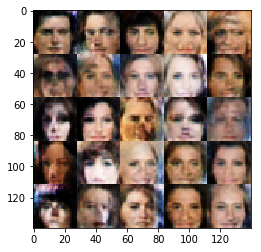

Epoch 1/3... Discriminator Loss: 1.4711... Generator Loss: 0.6578
Epoch 1/3... Discriminator Loss: 1.4453... Generator Loss: 0.7121
Epoch 1/3... Discriminator Loss: 1.3970... Generator Loss: 0.6390
Epoch 1/3... Discriminator Loss: 1.3969... Generator Loss: 0.7974
Epoch 1/3... Discriminator Loss: 1.5025... Generator Loss: 0.7751


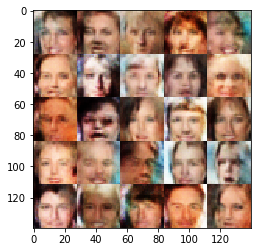

Epoch 1/3... Discriminator Loss: 1.4611... Generator Loss: 0.7880
Epoch 1/3... Discriminator Loss: 1.4621... Generator Loss: 0.6437
Epoch 1/3... Discriminator Loss: 1.4367... Generator Loss: 0.6453
Epoch 1/3... Discriminator Loss: 1.4587... Generator Loss: 0.7138
Epoch 1/3... Discriminator Loss: 1.4396... Generator Loss: 0.7679


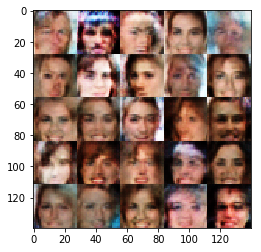

Epoch 1/3... Discriminator Loss: 1.4841... Generator Loss: 0.6260
Epoch 1/3... Discriminator Loss: 1.5047... Generator Loss: 0.7150
Epoch 1/3... Discriminator Loss: 1.4512... Generator Loss: 0.7438
Epoch 1/3... Discriminator Loss: 1.4771... Generator Loss: 0.7091
Epoch 1/3... Discriminator Loss: 1.4353... Generator Loss: 0.7503


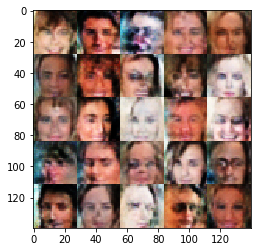

Epoch 1/3... Discriminator Loss: 1.4310... Generator Loss: 0.8085
Epoch 1/3... Discriminator Loss: 1.4259... Generator Loss: 0.6547
Epoch 1/3... Discriminator Loss: 1.4595... Generator Loss: 0.6207
Epoch 1/3... Discriminator Loss: 1.4951... Generator Loss: 0.6451
Epoch 1/3... Discriminator Loss: 1.4685... Generator Loss: 0.8024


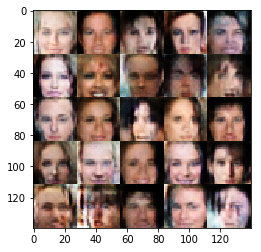

Epoch 1/3... Discriminator Loss: 1.4070... Generator Loss: 0.7116
Epoch 1/3... Discriminator Loss: 1.4560... Generator Loss: 0.7318
Epoch 1/3... Discriminator Loss: 1.4416... Generator Loss: 0.6409
Epoch 1/3... Discriminator Loss: 1.4325... Generator Loss: 0.8231
Epoch 1/3... Discriminator Loss: 1.4589... Generator Loss: 0.7033


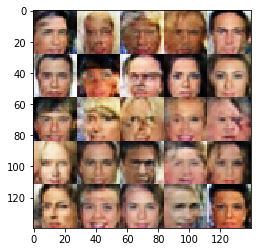

Epoch 1/3... Discriminator Loss: 1.4576... Generator Loss: 0.6919
Epoch 1/3... Discriminator Loss: 1.4243... Generator Loss: 0.7823
Epoch 1/3... Discriminator Loss: 1.5173... Generator Loss: 0.7345
Epoch 1/3... Discriminator Loss: 1.4689... Generator Loss: 0.8110
Epoch 1/3... Discriminator Loss: 1.4361... Generator Loss: 0.7053


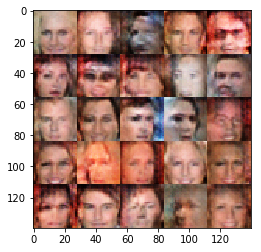

Epoch 1/3... Discriminator Loss: 1.4517... Generator Loss: 0.7523
Epoch 1/3... Discriminator Loss: 1.4182... Generator Loss: 0.8050
Epoch 1/3... Discriminator Loss: 1.4462... Generator Loss: 0.7197
Epoch 1/3... Discriminator Loss: 1.4503... Generator Loss: 0.7155
Epoch 1/3... Discriminator Loss: 1.4686... Generator Loss: 0.6981


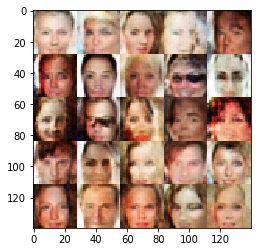

Epoch 1/3... Discriminator Loss: 1.4712... Generator Loss: 0.7206
Epoch 1/3... Discriminator Loss: 1.4182... Generator Loss: 0.7041
Epoch 1/3... Discriminator Loss: 1.4463... Generator Loss: 0.7895
Epoch 1/3... Discriminator Loss: 1.4464... Generator Loss: 0.7964
Epoch 1/3... Discriminator Loss: 1.4650... Generator Loss: 0.6389


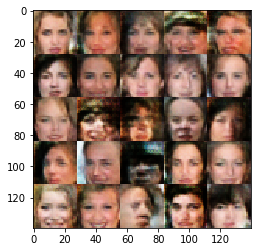

Epoch 1/3... Discriminator Loss: 1.3847... Generator Loss: 0.7971
Epoch 1/3... Discriminator Loss: 1.4202... Generator Loss: 0.7587
Epoch 1/3... Discriminator Loss: 1.4729... Generator Loss: 0.7096
Epoch 1/3... Discriminator Loss: 1.4343... Generator Loss: 0.6860
Epoch 2/3... Discriminator Loss: 1.4418... Generator Loss: 0.7263


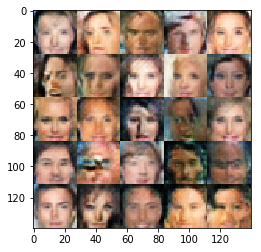

Epoch 2/3... Discriminator Loss: 1.4549... Generator Loss: 0.7212
Epoch 2/3... Discriminator Loss: 1.4517... Generator Loss: 0.6718
Epoch 2/3... Discriminator Loss: 1.4206... Generator Loss: 0.8038
Epoch 2/3... Discriminator Loss: 1.4560... Generator Loss: 0.7048
Epoch 2/3... Discriminator Loss: 1.4430... Generator Loss: 0.6906


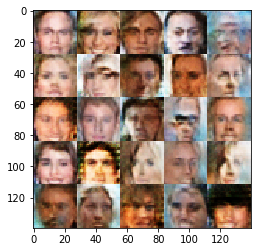

Epoch 2/3... Discriminator Loss: 1.4497... Generator Loss: 0.8568
Epoch 2/3... Discriminator Loss: 1.4097... Generator Loss: 0.7609
Epoch 2/3... Discriminator Loss: 1.5362... Generator Loss: 0.6585
Epoch 2/3... Discriminator Loss: 1.4345... Generator Loss: 0.7406
Epoch 2/3... Discriminator Loss: 1.4335... Generator Loss: 0.7273


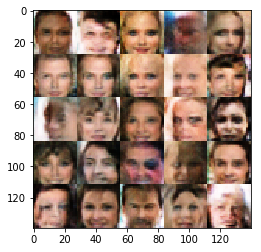

Epoch 2/3... Discriminator Loss: 1.4535... Generator Loss: 0.7327
Epoch 2/3... Discriminator Loss: 1.3983... Generator Loss: 0.7954
Epoch 2/3... Discriminator Loss: 1.4466... Generator Loss: 0.7278
Epoch 2/3... Discriminator Loss: 1.4427... Generator Loss: 0.6380
Epoch 2/3... Discriminator Loss: 1.4500... Generator Loss: 0.6680


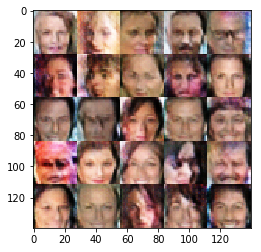

Epoch 2/3... Discriminator Loss: 1.4619... Generator Loss: 0.6282
Epoch 2/3... Discriminator Loss: 1.4524... Generator Loss: 0.7033
Epoch 2/3... Discriminator Loss: 1.4451... Generator Loss: 0.8345
Epoch 2/3... Discriminator Loss: 1.4458... Generator Loss: 0.6847
Epoch 2/3... Discriminator Loss: 1.4190... Generator Loss: 0.7625


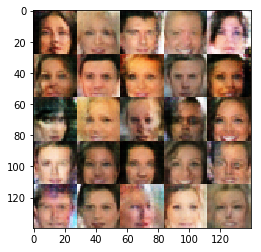

Epoch 2/3... Discriminator Loss: 1.4441... Generator Loss: 0.8287
Epoch 2/3... Discriminator Loss: 1.4744... Generator Loss: 0.6596
Epoch 2/3... Discriminator Loss: 1.4447... Generator Loss: 0.7800
Epoch 2/3... Discriminator Loss: 1.4429... Generator Loss: 0.7200
Epoch 2/3... Discriminator Loss: 1.4227... Generator Loss: 0.7622


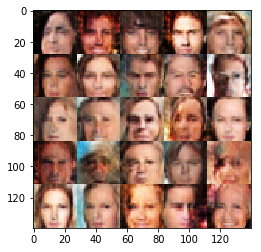

Epoch 2/3... Discriminator Loss: 1.4149... Generator Loss: 0.7553
Epoch 2/3... Discriminator Loss: 1.4416... Generator Loss: 0.6563
Epoch 2/3... Discriminator Loss: 1.3778... Generator Loss: 0.7574
Epoch 2/3... Discriminator Loss: 1.4083... Generator Loss: 0.7796
Epoch 2/3... Discriminator Loss: 1.4539... Generator Loss: 0.6354


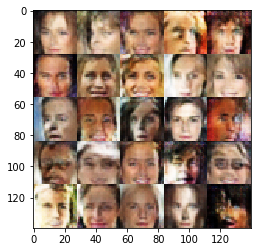

Epoch 2/3... Discriminator Loss: 1.4136... Generator Loss: 0.7210
Epoch 2/3... Discriminator Loss: 1.3968... Generator Loss: 0.7863
Epoch 2/3... Discriminator Loss: 1.4355... Generator Loss: 0.7524
Epoch 2/3... Discriminator Loss: 1.4493... Generator Loss: 0.7624
Epoch 2/3... Discriminator Loss: 1.4173... Generator Loss: 0.7820


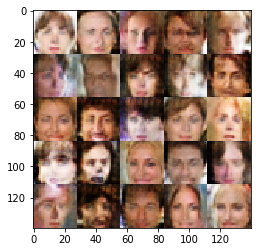

Epoch 2/3... Discriminator Loss: 1.4174... Generator Loss: 0.7131
Epoch 2/3... Discriminator Loss: 1.4289... Generator Loss: 0.8159
Epoch 2/3... Discriminator Loss: 1.3884... Generator Loss: 0.8257
Epoch 2/3... Discriminator Loss: 1.4406... Generator Loss: 0.7093
Epoch 2/3... Discriminator Loss: 1.4241... Generator Loss: 0.6484


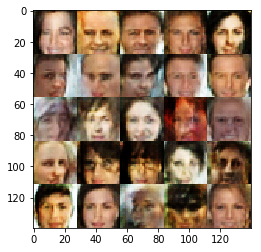

Epoch 2/3... Discriminator Loss: 1.4464... Generator Loss: 0.7045
Epoch 2/3... Discriminator Loss: 1.4692... Generator Loss: 0.7152
Epoch 2/3... Discriminator Loss: 1.4213... Generator Loss: 0.7149
Epoch 2/3... Discriminator Loss: 1.4141... Generator Loss: 0.7069
Epoch 2/3... Discriminator Loss: 1.4246... Generator Loss: 0.6745


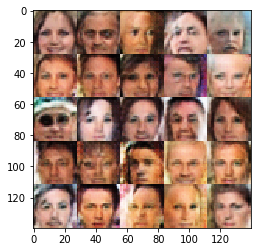

Epoch 2/3... Discriminator Loss: 1.4391... Generator Loss: 0.7740
Epoch 2/3... Discriminator Loss: 1.3855... Generator Loss: 0.8362
Epoch 2/3... Discriminator Loss: 1.4617... Generator Loss: 0.7715
Epoch 2/3... Discriminator Loss: 1.4322... Generator Loss: 0.6540
Epoch 2/3... Discriminator Loss: 1.4029... Generator Loss: 0.7146


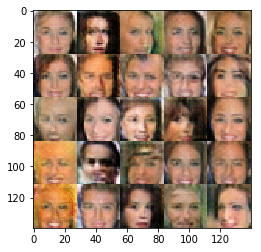

Epoch 2/3... Discriminator Loss: 1.4189... Generator Loss: 0.7093
Epoch 2/3... Discriminator Loss: 1.4615... Generator Loss: 0.7721
Epoch 2/3... Discriminator Loss: 1.4113... Generator Loss: 0.6738
Epoch 2/3... Discriminator Loss: 1.3947... Generator Loss: 0.7185
Epoch 2/3... Discriminator Loss: 1.4181... Generator Loss: 0.7458


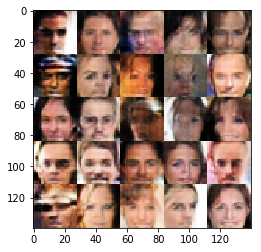

Epoch 2/3... Discriminator Loss: 1.4687... Generator Loss: 0.7014
Epoch 2/3... Discriminator Loss: 1.4970... Generator Loss: 0.7249
Epoch 2/3... Discriminator Loss: 1.4426... Generator Loss: 0.7215
Epoch 2/3... Discriminator Loss: 1.4018... Generator Loss: 0.7828
Epoch 2/3... Discriminator Loss: 1.4335... Generator Loss: 0.6790


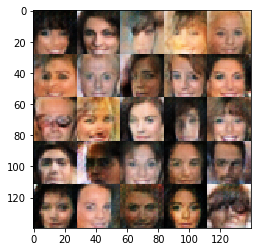

Epoch 2/3... Discriminator Loss: 1.4416... Generator Loss: 0.6695
Epoch 2/3... Discriminator Loss: 1.4231... Generator Loss: 0.7549
Epoch 2/3... Discriminator Loss: 1.4224... Generator Loss: 0.7478
Epoch 2/3... Discriminator Loss: 1.4473... Generator Loss: 0.7138
Epoch 2/3... Discriminator Loss: 1.4487... Generator Loss: 0.7505


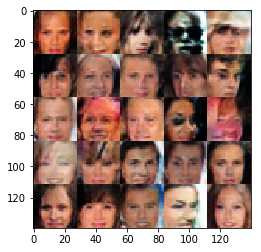

Epoch 2/3... Discriminator Loss: 1.4882... Generator Loss: 0.7465
Epoch 2/3... Discriminator Loss: 1.4184... Generator Loss: 0.8095
Epoch 2/3... Discriminator Loss: 1.4553... Generator Loss: 0.7565
Epoch 2/3... Discriminator Loss: 1.4084... Generator Loss: 0.7518
Epoch 2/3... Discriminator Loss: 1.4001... Generator Loss: 0.7306


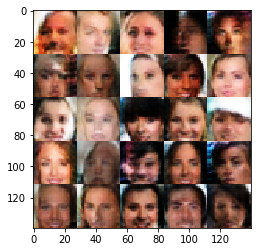

Epoch 2/3... Discriminator Loss: 1.3837... Generator Loss: 0.7533
Epoch 2/3... Discriminator Loss: 1.4080... Generator Loss: 0.6826
Epoch 2/3... Discriminator Loss: 1.4428... Generator Loss: 0.7633
Epoch 2/3... Discriminator Loss: 1.4267... Generator Loss: 0.6666
Epoch 2/3... Discriminator Loss: 1.4414... Generator Loss: 0.6921


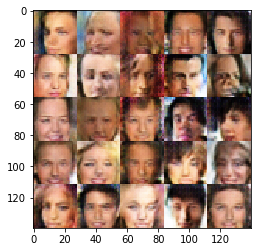

Epoch 2/3... Discriminator Loss: 1.4102... Generator Loss: 0.7266
Epoch 2/3... Discriminator Loss: 1.4512... Generator Loss: 0.7697
Epoch 2/3... Discriminator Loss: 1.4281... Generator Loss: 0.7448
Epoch 2/3... Discriminator Loss: 1.4559... Generator Loss: 0.7300
Epoch 2/3... Discriminator Loss: 1.4124... Generator Loss: 0.7348


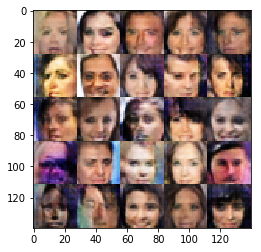

Epoch 2/3... Discriminator Loss: 1.3945... Generator Loss: 0.7897
Epoch 2/3... Discriminator Loss: 1.4417... Generator Loss: 0.7635
Epoch 2/3... Discriminator Loss: 1.4052... Generator Loss: 0.6880
Epoch 2/3... Discriminator Loss: 1.4617... Generator Loss: 0.7387
Epoch 2/3... Discriminator Loss: 1.4225... Generator Loss: 0.7867


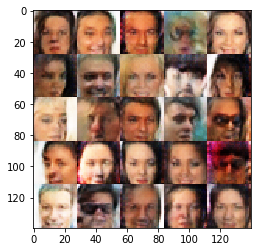

Epoch 2/3... Discriminator Loss: 1.4331... Generator Loss: 0.7485
Epoch 2/3... Discriminator Loss: 1.4679... Generator Loss: 0.8080
Epoch 2/3... Discriminator Loss: 1.4181... Generator Loss: 0.7530
Epoch 2/3... Discriminator Loss: 1.4320... Generator Loss: 0.7519
Epoch 2/3... Discriminator Loss: 1.3977... Generator Loss: 0.7528


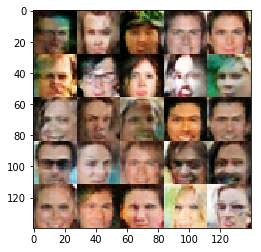

Epoch 2/3... Discriminator Loss: 1.4058... Generator Loss: 0.7340
Epoch 2/3... Discriminator Loss: 1.4463... Generator Loss: 0.7535
Epoch 2/3... Discriminator Loss: 1.4312... Generator Loss: 0.6930
Epoch 2/3... Discriminator Loss: 1.4062... Generator Loss: 0.7461
Epoch 2/3... Discriminator Loss: 1.4639... Generator Loss: 0.6808


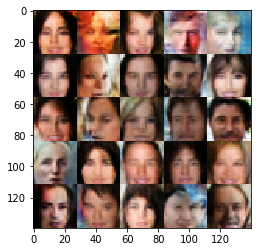

Epoch 2/3... Discriminator Loss: 1.4228... Generator Loss: 0.7562
Epoch 2/3... Discriminator Loss: 1.4009... Generator Loss: 0.7656
Epoch 2/3... Discriminator Loss: 1.4032... Generator Loss: 0.7274
Epoch 2/3... Discriminator Loss: 1.4130... Generator Loss: 0.6820
Epoch 2/3... Discriminator Loss: 1.4011... Generator Loss: 0.8268


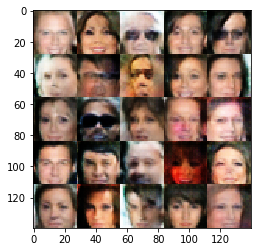

Epoch 2/3... Discriminator Loss: 1.3806... Generator Loss: 0.6902
Epoch 2/3... Discriminator Loss: 1.4106... Generator Loss: 0.7981
Epoch 2/3... Discriminator Loss: 1.4065... Generator Loss: 0.8213
Epoch 2/3... Discriminator Loss: 1.4092... Generator Loss: 0.6937
Epoch 2/3... Discriminator Loss: 1.4129... Generator Loss: 0.7507


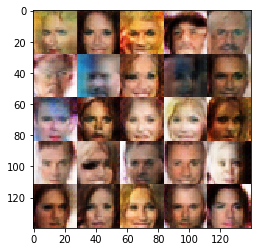

Epoch 2/3... Discriminator Loss: 1.4259... Generator Loss: 0.8006
Epoch 2/3... Discriminator Loss: 1.4037... Generator Loss: 0.8278
Epoch 2/3... Discriminator Loss: 1.4159... Generator Loss: 0.8028
Epoch 2/3... Discriminator Loss: 1.4164... Generator Loss: 0.7606
Epoch 2/3... Discriminator Loss: 1.3939... Generator Loss: 0.7043


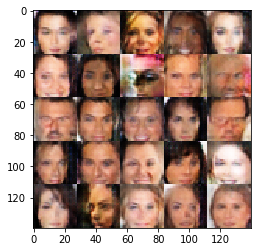

Epoch 2/3... Discriminator Loss: 1.3992... Generator Loss: 0.7023
Epoch 2/3... Discriminator Loss: 1.4209... Generator Loss: 0.7255
Epoch 2/3... Discriminator Loss: 1.3864... Generator Loss: 0.8414
Epoch 2/3... Discriminator Loss: 1.3881... Generator Loss: 0.7184
Epoch 2/3... Discriminator Loss: 1.4425... Generator Loss: 0.7163


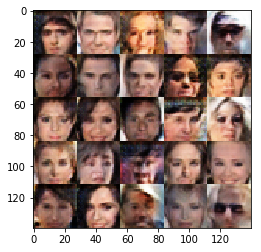

Epoch 2/3... Discriminator Loss: 1.4460... Generator Loss: 0.6888
Epoch 2/3... Discriminator Loss: 1.4167... Generator Loss: 0.7267
Epoch 2/3... Discriminator Loss: 1.4287... Generator Loss: 0.7885
Epoch 2/3... Discriminator Loss: 1.3901... Generator Loss: 0.7349
Epoch 2/3... Discriminator Loss: 1.4277... Generator Loss: 0.6521


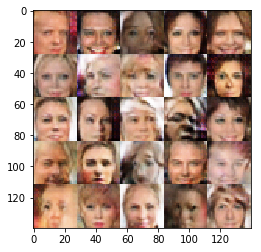

Epoch 2/3... Discriminator Loss: 1.4373... Generator Loss: 0.7290
Epoch 2/3... Discriminator Loss: 1.3968... Generator Loss: 0.7543
Epoch 2/3... Discriminator Loss: 1.4149... Generator Loss: 0.7239
Epoch 2/3... Discriminator Loss: 1.4032... Generator Loss: 0.7211
Epoch 2/3... Discriminator Loss: 1.4438... Generator Loss: 0.7236


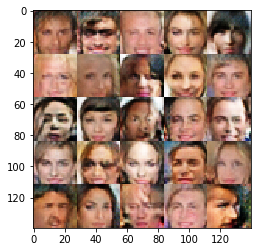

Epoch 2/3... Discriminator Loss: 1.4344... Generator Loss: 0.6586
Epoch 2/3... Discriminator Loss: 1.4169... Generator Loss: 0.6975
Epoch 2/3... Discriminator Loss: 1.4365... Generator Loss: 0.7074
Epoch 2/3... Discriminator Loss: 1.3959... Generator Loss: 0.7445
Epoch 2/3... Discriminator Loss: 1.3920... Generator Loss: 0.7748


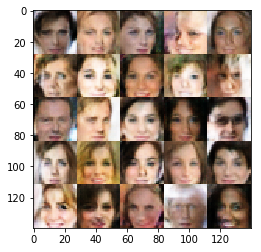

Epoch 2/3... Discriminator Loss: 1.4167... Generator Loss: 0.7265
Epoch 2/3... Discriminator Loss: 1.4080... Generator Loss: 0.8234
Epoch 2/3... Discriminator Loss: 1.4000... Generator Loss: 0.7928
Epoch 2/3... Discriminator Loss: 1.4213... Generator Loss: 0.7619
Epoch 2/3... Discriminator Loss: 1.4050... Generator Loss: 0.7667


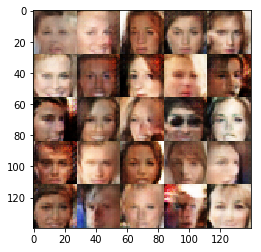

Epoch 2/3... Discriminator Loss: 1.3978... Generator Loss: 0.8041
Epoch 2/3... Discriminator Loss: 1.4207... Generator Loss: 0.7869
Epoch 2/3... Discriminator Loss: 1.4269... Generator Loss: 0.7197
Epoch 2/3... Discriminator Loss: 1.4193... Generator Loss: 0.7966
Epoch 2/3... Discriminator Loss: 1.4210... Generator Loss: 0.6978


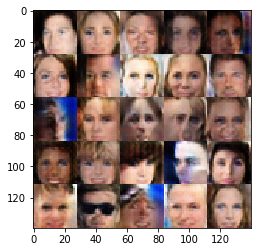

Epoch 2/3... Discriminator Loss: 1.3970... Generator Loss: 0.7287
Epoch 2/3... Discriminator Loss: 1.4232... Generator Loss: 0.7532
Epoch 2/3... Discriminator Loss: 1.4164... Generator Loss: 0.6973
Epoch 2/3... Discriminator Loss: 1.4255... Generator Loss: 0.7571
Epoch 2/3... Discriminator Loss: 1.4080... Generator Loss: 0.7612


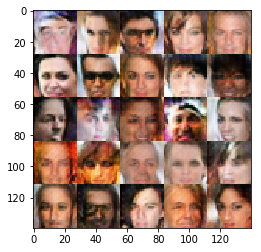

Epoch 2/3... Discriminator Loss: 1.3902... Generator Loss: 0.7709
Epoch 2/3... Discriminator Loss: 1.4237... Generator Loss: 0.6904
Epoch 2/3... Discriminator Loss: 1.3962... Generator Loss: 0.7359
Epoch 2/3... Discriminator Loss: 1.4183... Generator Loss: 0.7067
Epoch 2/3... Discriminator Loss: 1.4172... Generator Loss: 0.7647


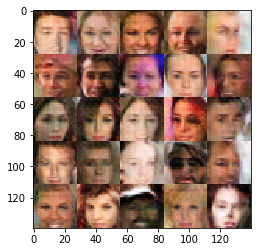

Epoch 2/3... Discriminator Loss: 1.3975... Generator Loss: 0.7336
Epoch 2/3... Discriminator Loss: 1.3878... Generator Loss: 0.7022
Epoch 2/3... Discriminator Loss: 1.4072... Generator Loss: 0.7315
Epoch 2/3... Discriminator Loss: 1.3882... Generator Loss: 0.7654
Epoch 2/3... Discriminator Loss: 1.4158... Generator Loss: 0.8194


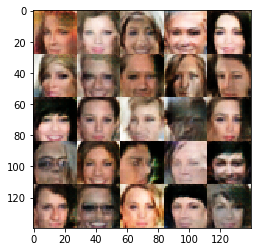

Epoch 2/3... Discriminator Loss: 1.4058... Generator Loss: 0.7165
Epoch 2/3... Discriminator Loss: 1.4080... Generator Loss: 0.6805
Epoch 3/3... Discriminator Loss: 1.3992... Generator Loss: 0.6770
Epoch 3/3... Discriminator Loss: 1.4187... Generator Loss: 0.7269
Epoch 3/3... Discriminator Loss: 1.4042... Generator Loss: 0.6854


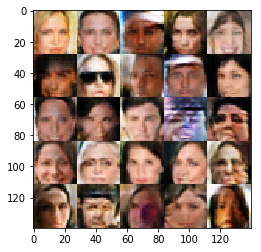

Epoch 3/3... Discriminator Loss: 1.3950... Generator Loss: 0.7973
Epoch 3/3... Discriminator Loss: 1.4191... Generator Loss: 0.8129
Epoch 3/3... Discriminator Loss: 1.3923... Generator Loss: 0.7420
Epoch 3/3... Discriminator Loss: 1.3868... Generator Loss: 0.8669
Epoch 3/3... Discriminator Loss: 1.4366... Generator Loss: 0.7225


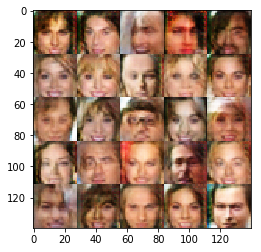

Epoch 3/3... Discriminator Loss: 1.3968... Generator Loss: 0.7397
Epoch 3/3... Discriminator Loss: 1.4475... Generator Loss: 0.6815
Epoch 3/3... Discriminator Loss: 1.3917... Generator Loss: 0.7769
Epoch 3/3... Discriminator Loss: 1.4278... Generator Loss: 0.7528
Epoch 3/3... Discriminator Loss: 1.4216... Generator Loss: 0.7615


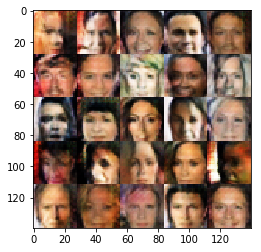

Epoch 3/3... Discriminator Loss: 1.4049... Generator Loss: 0.7916
Epoch 3/3... Discriminator Loss: 1.4212... Generator Loss: 0.7243
Epoch 3/3... Discriminator Loss: 1.3899... Generator Loss: 0.7807
Epoch 3/3... Discriminator Loss: 1.3993... Generator Loss: 0.8005
Epoch 3/3... Discriminator Loss: 1.4250... Generator Loss: 0.7204


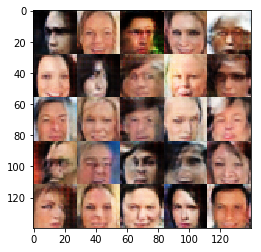

Epoch 3/3... Discriminator Loss: 1.4037... Generator Loss: 0.8313
Epoch 3/3... Discriminator Loss: 1.4132... Generator Loss: 0.7705
Epoch 3/3... Discriminator Loss: 1.3919... Generator Loss: 0.7783
Epoch 3/3... Discriminator Loss: 1.4334... Generator Loss: 0.7725
Epoch 3/3... Discriminator Loss: 1.4066... Generator Loss: 0.7381


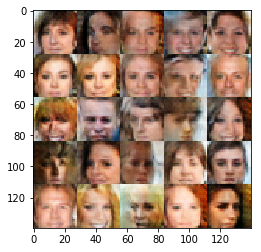

Epoch 3/3... Discriminator Loss: 1.4168... Generator Loss: 0.6918
Epoch 3/3... Discriminator Loss: 1.4227... Generator Loss: 0.7220
Epoch 3/3... Discriminator Loss: 1.4098... Generator Loss: 0.7005
Epoch 3/3... Discriminator Loss: 1.4133... Generator Loss: 0.7189
Epoch 3/3... Discriminator Loss: 1.3985... Generator Loss: 0.7426


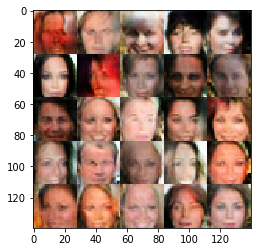

Epoch 3/3... Discriminator Loss: 1.3932... Generator Loss: 0.8515
Epoch 3/3... Discriminator Loss: 1.4020... Generator Loss: 0.7591
Epoch 3/3... Discriminator Loss: 1.4240... Generator Loss: 0.7253
Epoch 3/3... Discriminator Loss: 1.4139... Generator Loss: 0.6632
Epoch 3/3... Discriminator Loss: 1.4235... Generator Loss: 0.6982


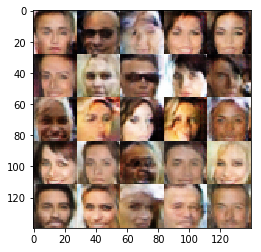

Epoch 3/3... Discriminator Loss: 1.4043... Generator Loss: 0.7896
Epoch 3/3... Discriminator Loss: 1.4425... Generator Loss: 0.7836
Epoch 3/3... Discriminator Loss: 1.4095... Generator Loss: 0.7386
Epoch 3/3... Discriminator Loss: 1.4428... Generator Loss: 0.7907
Epoch 3/3... Discriminator Loss: 1.3994... Generator Loss: 0.8205


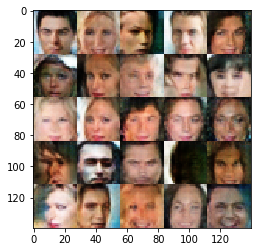

Epoch 3/3... Discriminator Loss: 1.4023... Generator Loss: 0.7112
Epoch 3/3... Discriminator Loss: 1.4126... Generator Loss: 0.7449
Epoch 3/3... Discriminator Loss: 1.3904... Generator Loss: 0.8258
Epoch 3/3... Discriminator Loss: 1.3981... Generator Loss: 0.7680
Epoch 3/3... Discriminator Loss: 1.4020... Generator Loss: 0.7784


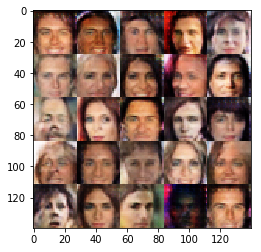

Epoch 3/3... Discriminator Loss: 1.4002... Generator Loss: 0.7577
Epoch 3/3... Discriminator Loss: 1.3875... Generator Loss: 0.8407
Epoch 3/3... Discriminator Loss: 1.3966... Generator Loss: 0.7596
Epoch 3/3... Discriminator Loss: 1.4017... Generator Loss: 0.7333
Epoch 3/3... Discriminator Loss: 1.4067... Generator Loss: 0.7306


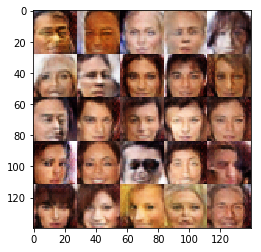

Epoch 3/3... Discriminator Loss: 1.3877... Generator Loss: 0.7531
Epoch 3/3... Discriminator Loss: 1.3995... Generator Loss: 0.7363
Epoch 3/3... Discriminator Loss: 1.4136... Generator Loss: 0.7861
Epoch 3/3... Discriminator Loss: 1.4047... Generator Loss: 0.8095
Epoch 3/3... Discriminator Loss: 1.3926... Generator Loss: 0.7610


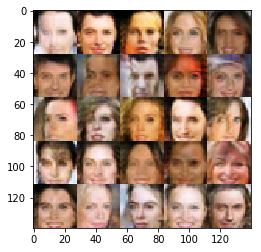

Epoch 3/3... Discriminator Loss: 1.4394... Generator Loss: 0.8516
Epoch 3/3... Discriminator Loss: 1.4032... Generator Loss: 0.7759
Epoch 3/3... Discriminator Loss: 1.4215... Generator Loss: 0.6800
Epoch 3/3... Discriminator Loss: 1.4024... Generator Loss: 0.8145
Epoch 3/3... Discriminator Loss: 1.4553... Generator Loss: 0.6926


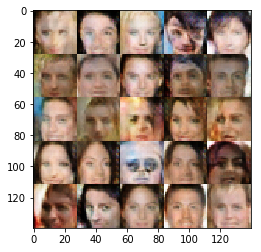

Epoch 3/3... Discriminator Loss: 1.3962... Generator Loss: 0.7623
Epoch 3/3... Discriminator Loss: 1.4170... Generator Loss: 0.7770
Epoch 3/3... Discriminator Loss: 1.3992... Generator Loss: 0.7527
Epoch 3/3... Discriminator Loss: 1.4123... Generator Loss: 0.7608
Epoch 3/3... Discriminator Loss: 1.4053... Generator Loss: 0.8613


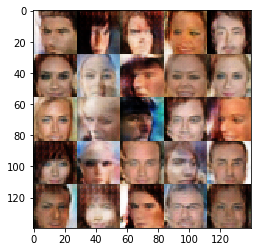

Epoch 3/3... Discriminator Loss: 1.4065... Generator Loss: 0.8004
Epoch 3/3... Discriminator Loss: 1.3951... Generator Loss: 0.8316
Epoch 3/3... Discriminator Loss: 1.4022... Generator Loss: 0.7614
Epoch 3/3... Discriminator Loss: 1.4153... Generator Loss: 0.7274
Epoch 3/3... Discriminator Loss: 1.4099... Generator Loss: 0.7536


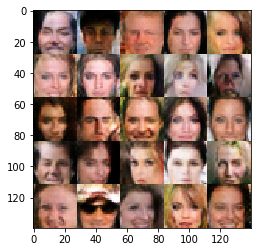

Epoch 3/3... Discriminator Loss: 1.4084... Generator Loss: 0.7903
Epoch 3/3... Discriminator Loss: 1.4121... Generator Loss: 0.7381
Epoch 3/3... Discriminator Loss: 1.4190... Generator Loss: 0.8121
Epoch 3/3... Discriminator Loss: 1.4081... Generator Loss: 0.7571
Epoch 3/3... Discriminator Loss: 1.4048... Generator Loss: 0.7985


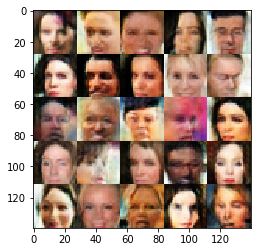

Epoch 3/3... Discriminator Loss: 1.4051... Generator Loss: 0.7959
Epoch 3/3... Discriminator Loss: 1.4073... Generator Loss: 0.7259
Epoch 3/3... Discriminator Loss: 1.4299... Generator Loss: 0.6539
Epoch 3/3... Discriminator Loss: 1.4020... Generator Loss: 0.7770
Epoch 3/3... Discriminator Loss: 1.4157... Generator Loss: 0.7482


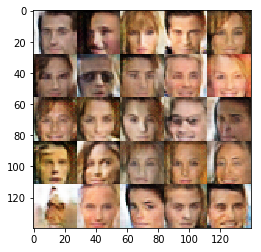

Epoch 3/3... Discriminator Loss: 1.4301... Generator Loss: 0.6983
Epoch 3/3... Discriminator Loss: 1.3942... Generator Loss: 0.7772
Epoch 3/3... Discriminator Loss: 1.4069... Generator Loss: 0.7337
Epoch 3/3... Discriminator Loss: 1.4099... Generator Loss: 0.7497
Epoch 3/3... Discriminator Loss: 1.4134... Generator Loss: 0.6673


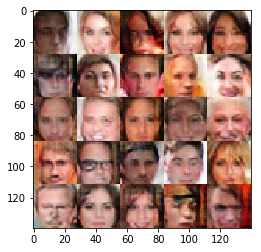

Epoch 3/3... Discriminator Loss: 1.4197... Generator Loss: 0.8576
Epoch 3/3... Discriminator Loss: 1.4061... Generator Loss: 0.7854
Epoch 3/3... Discriminator Loss: 1.3899... Generator Loss: 0.7770
Epoch 3/3... Discriminator Loss: 1.3788... Generator Loss: 0.7373
Epoch 3/3... Discriminator Loss: 1.3984... Generator Loss: 0.8205


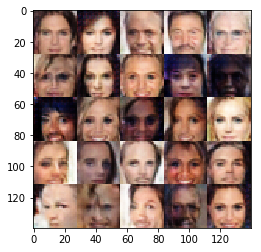

Epoch 3/3... Discriminator Loss: 1.4012... Generator Loss: 0.7995
Epoch 3/3... Discriminator Loss: 1.3828... Generator Loss: 0.8150
Epoch 3/3... Discriminator Loss: 1.4087... Generator Loss: 0.7513
Epoch 3/3... Discriminator Loss: 1.4099... Generator Loss: 0.8045
Epoch 3/3... Discriminator Loss: 1.3936... Generator Loss: 0.7775


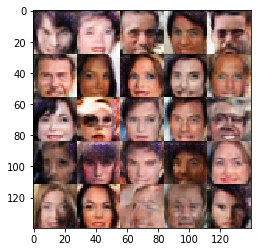

Epoch 3/3... Discriminator Loss: 1.4001... Generator Loss: 0.7525
Epoch 3/3... Discriminator Loss: 1.3865... Generator Loss: 0.6481
Epoch 3/3... Discriminator Loss: 1.3895... Generator Loss: 0.7650
Epoch 3/3... Discriminator Loss: 1.4339... Generator Loss: 0.7604
Epoch 3/3... Discriminator Loss: 1.4027... Generator Loss: 0.8301


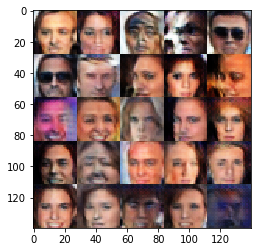

Epoch 3/3... Discriminator Loss: 1.3955... Generator Loss: 0.7843
Epoch 3/3... Discriminator Loss: 1.4020... Generator Loss: 0.7485
Epoch 3/3... Discriminator Loss: 1.3879... Generator Loss: 0.7489
Epoch 3/3... Discriminator Loss: 1.3906... Generator Loss: 0.7884
Epoch 3/3... Discriminator Loss: 1.4149... Generator Loss: 0.7168


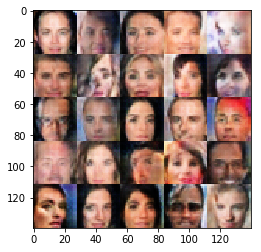

Epoch 3/3... Discriminator Loss: 1.4170... Generator Loss: 0.7614
Epoch 3/3... Discriminator Loss: 1.4205... Generator Loss: 0.7565
Epoch 3/3... Discriminator Loss: 1.4208... Generator Loss: 0.7581
Epoch 3/3... Discriminator Loss: 1.3955... Generator Loss: 0.8277
Epoch 3/3... Discriminator Loss: 1.4097... Generator Loss: 0.7160


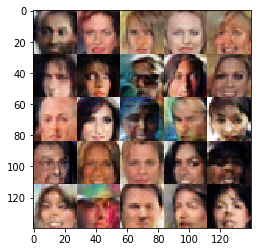

Epoch 3/3... Discriminator Loss: 1.4166... Generator Loss: 0.7003
Epoch 3/3... Discriminator Loss: 1.3856... Generator Loss: 0.7682
Epoch 3/3... Discriminator Loss: 1.4138... Generator Loss: 0.7389
Epoch 3/3... Discriminator Loss: 1.3925... Generator Loss: 0.7465
Epoch 3/3... Discriminator Loss: 1.3889... Generator Loss: 0.7284


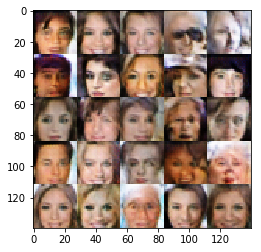

Epoch 3/3... Discriminator Loss: 1.4040... Generator Loss: 0.7022
Epoch 3/3... Discriminator Loss: 1.4119... Generator Loss: 0.7773
Epoch 3/3... Discriminator Loss: 1.4073... Generator Loss: 0.7265
Epoch 3/3... Discriminator Loss: 1.4144... Generator Loss: 0.7623
Epoch 3/3... Discriminator Loss: 1.3963... Generator Loss: 0.7446


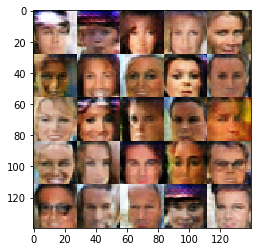

Epoch 3/3... Discriminator Loss: 1.4100... Generator Loss: 0.8081
Epoch 3/3... Discriminator Loss: 1.4089... Generator Loss: 0.7712
Epoch 3/3... Discriminator Loss: 1.4041... Generator Loss: 0.8280
Epoch 3/3... Discriminator Loss: 1.3929... Generator Loss: 0.7691
Epoch 3/3... Discriminator Loss: 1.4237... Generator Loss: 0.7718


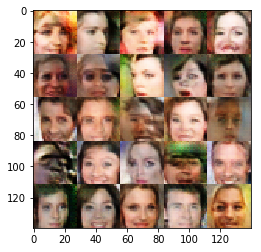

Epoch 3/3... Discriminator Loss: 1.3914... Generator Loss: 0.8505
Epoch 3/3... Discriminator Loss: 1.3984... Generator Loss: 0.7862
Epoch 3/3... Discriminator Loss: 1.3827... Generator Loss: 0.7952
Epoch 3/3... Discriminator Loss: 1.4000... Generator Loss: 0.7510
Epoch 3/3... Discriminator Loss: 1.4042... Generator Loss: 0.7023


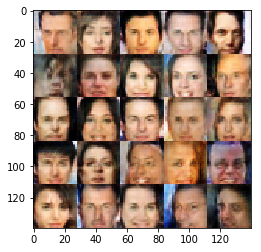

Epoch 3/3... Discriminator Loss: 1.4050... Generator Loss: 0.8337
Epoch 3/3... Discriminator Loss: 1.4021... Generator Loss: 0.7386
Epoch 3/3... Discriminator Loss: 1.3865... Generator Loss: 0.7673
Epoch 3/3... Discriminator Loss: 1.4145... Generator Loss: 0.7561
Epoch 3/3... Discriminator Loss: 1.4063... Generator Loss: 0.6887


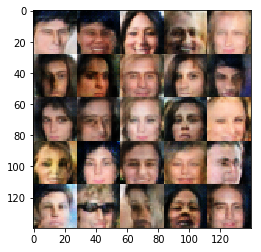

Epoch 3/3... Discriminator Loss: 1.3968... Generator Loss: 0.7553
Epoch 3/3... Discriminator Loss: 1.4374... Generator Loss: 0.7816
Epoch 3/3... Discriminator Loss: 1.4122... Generator Loss: 0.8870
Epoch 3/3... Discriminator Loss: 1.3853... Generator Loss: 0.7231
Epoch 3/3... Discriminator Loss: 1.4100... Generator Loss: 0.7877


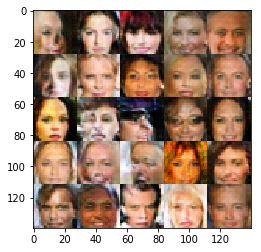

Epoch 3/3... Discriminator Loss: 1.4076... Generator Loss: 0.7210
Epoch 3/3... Discriminator Loss: 1.3988... Generator Loss: 0.7455
Epoch 3/3... Discriminator Loss: 1.4180... Generator Loss: 0.7514
Epoch 3/3... Discriminator Loss: 1.4117... Generator Loss: 0.7228
Epoch 3/3... Discriminator Loss: 1.4016... Generator Loss: 0.7641


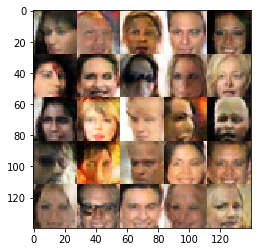

Epoch 3/3... Discriminator Loss: 1.3823... Generator Loss: 0.7180
Epoch 3/3... Discriminator Loss: 1.3965... Generator Loss: 0.8075
Epoch 3/3... Discriminator Loss: 1.4008... Generator Loss: 0.7969
Epoch 3/3... Discriminator Loss: 1.3856... Generator Loss: 0.7815
Epoch 3/3... Discriminator Loss: 1.3894... Generator Loss: 0.6862


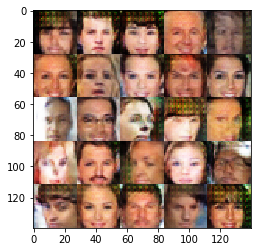

Epoch 3/3... Discriminator Loss: 1.3834... Generator Loss: 0.8360
Epoch 3/3... Discriminator Loss: 1.3939... Generator Loss: 0.7296
Epoch 3/3... Discriminator Loss: 1.3867... Generator Loss: 0.7894
Epoch 3/3... Discriminator Loss: 1.4209... Generator Loss: 0.8154
Epoch 3/3... Discriminator Loss: 1.3919... Generator Loss: 0.7805


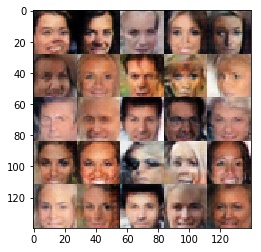

Epoch 3/3... Discriminator Loss: 1.3940... Generator Loss: 0.8003
Epoch 3/3... Discriminator Loss: 1.4067... Generator Loss: 0.7984
Epoch 3/3... Discriminator Loss: 1.4170... Generator Loss: 0.6547
Epoch 3/3... Discriminator Loss: 1.4018... Generator Loss: 0.7385
Epoch 3/3... Discriminator Loss: 1.4010... Generator Loss: 0.7764


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)